<a href="https://colab.research.google.com/github/Foysal061/EmergencyDepartmentPatientPred/blob/main/BiDirectionalLstmStepWiseForecastwithPlotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install openmeteo-requests requests-cache retry-requests numpy pandas tensorflow scikit-learn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import openmeteo_requests
import requests_cache
from retry_requests import retry
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)
print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
def load_ed_data(filepath, separator=';'):
    """Load ED data from CSV"""
    print("\n[1/8] Loading ED data...")
    df = pd.read_csv(filepath, sep=separator)
    df.columns = ['arrival', 'departure', 'first_doctor_response', 'first_triage']
    print(f"Loaded {len(df)} records")
    print(df.head())
    return df
df = load_ed_data("/content/drive/MyDrive/Colab Notebooks/VestfoldTriageReport.csv")


[1/8] Loading ED data...
Loaded 35674 records
            arrival         departure first_doctor_response   first_triage
0  01.10.2023 13:46  06.10.2023 18:10            LessUrgent  Resuscitation
1  01.10.2023 14:20  20.10.2023 11:37            LessUrgent     LessUrgent
2  01.10.2023 13:59  03.10.2023 12:04                   NaN  Resuscitation
3  01.10.2023 14:40  01.10.2023 17:30            LessUrgent     LessUrgent
4  01.10.2023 13:50  01.10.2023 20:45             NotUrgent         Urgent


In [ ]:
def parse_datetime_columns(df):
    print("Parsing datetime fields.")

    # Convert to datetime, invalid parsing becomes NaT
    df['arrival'] = pd.to_datetime(df['arrival'], format='%d.%m.%Y %H:%M', errors='coerce')
    df['departure'] = pd.to_datetime(df['departure'], format='%d.%m.%Y %H:%M', errors='coerce')

    # Drop rows where parsing failed
    df = df.dropna(subset=['arrival', 'departure'])

    df = df.sort_values('arrival')

    local_zone = 'Europe/Oslo'
    df['arrival'] = df['arrival'].dt.tz_localize(local_zone).dt.tz_convert('UTC').dt.tz_localize(None)
    df['departure'] = df['departure'].dt.tz_localize(local_zone).dt.tz_convert('UTC').dt.tz_localize(None)


    df['duration_minutes'] = (df['departure'] - df['arrival']).dt.total_seconds() / 60

    print(f"Parsed datetimes in UTC, {len(df)} records remaining")
    print(df.head())
    return df
df = parse_datetime_columns(df)

Parsing datetime fields.
Parsed datetimes in UTC, 35674 records remaining
              arrival           departure first_doctor_response  \
0 2023-10-01 11:46:00 2023-10-06 16:10:00            LessUrgent   
4 2023-10-01 11:50:00 2023-10-01 18:45:00             NotUrgent   
7 2023-10-01 11:59:00 2023-10-05 13:05:00                Urgent   
2 2023-10-01 11:59:00 2023-10-03 10:04:00                   NaN   
8 2023-10-01 12:20:00 2023-10-02 12:01:00            LessUrgent   

    first_triage  duration_minutes  
0  Resuscitation            7464.0  
4         Urgent             415.0  
7  Resuscitation            5826.0  
2  Resuscitation            2765.0  
8  Resuscitation            1421.0  


In [ ]:
def aggregate_to_hourly(df):
    """Aggregate data to hourly intervals"""
    print("\n[3/8] Aggregating to hourly intervals...")
    df['arrival_hour'] = df['arrival'].dt.floor('H')

    # Aggregate only essential metrics
    hourly_df = df.groupby('arrival_hour').agg({
        'arrival': 'count',
        'duration_minutes': ['mean', 'std']
    })

    hourly_df.columns = ['arrival_count', 'duration_mean', 'duration_std']
    hourly_df = hourly_df.reset_index()
    hourly_df[['duration_mean', 'duration_std']] = hourly_df[['duration_mean', 'duration_std']].fillna(0)

    print(f"Aggregated to {len(hourly_df)} hourly records")
    return hourly_df
df = aggregate_to_hourly(df)
print(df.head())


[3/8] Aggregating to hourly intervals...
Aggregated to 8284 hourly records
         arrival_hour  arrival_count  duration_mean  duration_std
0 2023-10-01 11:00:00              4    4117.500000   3144.084233
1 2023-10-01 12:00:00              6    6230.833333  10460.660083
2 2023-10-01 13:00:00              6    3253.166667   4289.686768
3 2023-10-01 14:00:00              3     671.000000    731.448563
4 2023-10-01 15:00:00              6    6644.500000   6639.924962


In [ ]:
# Fetch and merge weather data
def fetch_weather_data(start_date, end_date, is_hourly=False):
    """Fetch weather data from Open-Meteo API (hourly or daily)"""

    data_type = "hourly" if is_hourly else "daily"
    print(f"\n[5/8] Fetching {data_type} weather data...")

    cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://archive-api.open-meteo.com/v1/archive"

    # Build parameters based on is_hourly flag
    if is_hourly:
        params = {
            "latitude": 59.2725,
            "longitude": 10.4184,
            "start_date": start_date,
            "end_date": end_date,
            "hourly": [
                "temperature_2m",
                "relative_humidity_2m",
                "precipitation",
                "surface_pressure",
                "wind_speed_10m"
            ]
        }
    else:
        params = {
            "latitude": 59.2725,
            "longitude": 10.4184,
            "start_date": start_date,
            "end_date": end_date,
            "daily": [
                "temperature_2m_mean",
                "temperature_2m_max",
                "temperature_2m_min",
                "precipitation_sum",
                "rain_sum",
                "wind_speed_10m_max",
                "wind_speed_10m_mean"
            ]
        }

    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]

    # Build dataframe with essential weather features
    if is_hourly:
      hourly = response.Hourly()
      timestamps = pd.date_range(
          start=pd.to_datetime(hourly.Time(), unit="s"),
          end=pd.to_datetime(hourly.TimeEnd(), unit="s"),
          freq=pd.Timedelta(seconds=hourly.Interval()),
          inclusive="left"
      )
      hourly_data = {
          "date": timestamps,
          "temperature": hourly.Variables(0).ValuesAsNumpy().astype(float).round(2),
          "humidity": hourly.Variables(1).ValuesAsNumpy().astype(float).round(2),
          "precipitation": hourly.Variables(2).ValuesAsNumpy().astype(float).round(2),
          "pressure": hourly.Variables(3).ValuesAsNumpy().astype(float).round(2),
          "wind_speed": hourly.Variables(4).ValuesAsNumpy().astype(float).round(2)
      }

      weather_df = pd.DataFrame(hourly_data)
    else:
      # Process daily data
      daily = response.Daily()
      timestamps = pd.date_range(
          start=pd.to_datetime(daily.Time(), unit="s"),
          end=pd.to_datetime(daily.TimeEnd(), unit="s"),
          freq=pd.Timedelta(seconds=daily.Interval()),
          inclusive="left"
      )

      # Build dataframe with daily weather features
      daily_data = {
          "date": timestamps,
          "temp_mean": daily.Variables(0).ValuesAsNumpy().astype(float).round(2),
          "temp_max": daily.Variables(1).ValuesAsNumpy().astype(float).round(2),
          "temp_min": daily.Variables(2).ValuesAsNumpy().astype(float).round(2),
          "precipitation": daily.Variables(3).ValuesAsNumpy().astype(float).round(2),
          "rain": daily.Variables(4).ValuesAsNumpy().astype(float).round(2),
          "wind_max": daily.Variables(5).ValuesAsNumpy().astype(float).round(2),
          "wind_mean": daily.Variables(6).ValuesAsNumpy().astype(float).round(2)
      }

      weather_df = pd.DataFrame(daily_data)

    weather_df['date'] = pd.to_datetime(weather_df['date']).dt.tz_localize(None)

    print(f"Created weather dataframe with {len(weather_df)} records")
    return weather_df
weather_df = fetch_weather_data("2023-01-10", "2024-10-26", True)


[5/8] Fetching hourly weather data...
Created weather dataframe with 15744 records


In [ ]:
def merge_weather_data(df, weather_df, is_hourly = False):
    """Merge weather data with ED data"""
    print("\n[6/8] Merging weather data...")
    if is_hourly:
      col_name = 'arrival_hour'
    else:
      col_name = 'arrival_date'

    print(col_name)
    df[col_name] = pd.to_datetime(df[col_name], errors='coerce')
    weather_df['date'] = pd.to_datetime(weather_df['date'], errors='coerce')

    df = df.dropna(subset=[col_name])

    if is_hourly:
      merged_df = pd.merge_asof(
        df.sort_values("arrival_hour"),
        weather_df.sort_values("date"),
        left_on="arrival_hour",
        right_on="date",
        direction="nearest"
      )
    else:
      merged_df = pd.merge(
            df,
            weather_df,
            left_on="arrival_date",
            right_on="date",
            how="left"
        )

    # Drop the duplicate date column
    merged_df = merged_df.drop(columns=['date'], errors='ignore')

    print(f"Merged data: {len(merged_df)} records with {len(merged_df.columns)} total columns")
    print(merged_df.head())
    return merged_df
df = merge_weather_data(df, weather_df, True)


[6/8] Merging weather data...
arrival_hour
Merged data: 8284 records with 9 total columns
         arrival_hour  arrival_count  duration_mean  duration_std  \
0 2023-10-01 11:00:00              4    4117.500000   3144.084233   
1 2023-10-01 12:00:00              6    6230.833333  10460.660083   
2 2023-10-01 13:00:00              6    3253.166667   4289.686768   
3 2023-10-01 14:00:00              3     671.000000    731.448563   
4 2023-10-01 15:00:00              6    6644.500000   6639.924962   

   temperature  humidity  precipitation  pressure  wind_speed  
0        15.90     65.10            0.0   1012.48        9.34  
1        14.90     58.57            0.0   1012.97        3.67  
2        15.05     59.01            0.0   1012.87        6.29  
3        14.50     63.26            0.0   1012.47        9.11  
4        13.65     66.62            0.0   1011.96       10.46  


In [ ]:
def load_merge_infection_data(df, is_hourly=False):

  if is_hourly:
    col_name = 'arrival_hour'
  else:
    col_name = 'arrival_date'

  # Load the monthly infection data
  monthly_df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Infeksjonsdata.xlsx", header=0)
  monthly_df = monthly_df.rename(columns=lambda x: f'{x}_Infected_Patient_Monthly_Count' if x not in ['Month', 'Total_Infected_Patient_Monthly'] else x)

  df['year_month'] = df[col_name].dt.to_period('M')
  monthly_df['year_month'] = monthly_df['Month'].dt.to_period('M')

  df_merged = df.merge(
      monthly_df.drop('Month', axis=1),  # drop the original date column
      on='year_month',
      how='left'
  )

  df_merged = df_merged.drop('year_month', axis=1)

  print(df_merged.head())
  return df_merged
df = load_merge_infection_data(df, True)

         arrival_hour  arrival_count  duration_mean  duration_std  \
0 2023-10-01 11:00:00              4    4117.500000   3144.084233   
1 2023-10-01 12:00:00              6    6230.833333  10460.660083   
2 2023-10-01 13:00:00              6    3253.166667   4289.686768   
3 2023-10-01 14:00:00              3     671.000000    731.448563   
4 2023-10-01 15:00:00              6    6644.500000   6639.924962   

   temperature  humidity  precipitation  pressure  wind_speed  \
0        15.90     65.10            0.0   1012.48        9.34   
1        14.90     58.57            0.0   1012.97        3.67   
2        15.05     59.01            0.0   1012.87        6.29   
3        14.50     63.26            0.0   1012.47        9.11   
4        13.65     66.62            0.0   1011.96       10.46   

   Total_Infected_Patient_Monthly  ...  \
0                             616  ...   
1                             616  ...   
2                             616  ...   
3                         

In [ ]:
def create_lag_and_temporal_features(df, target_col='arrival_count', lags=[1], fill_method='drop', create_lead=True):
    """
    Create lag features for time series

    Args:
        df: DataFrame with time series data
        target_col: Column to create lags for
        lags: List of lag periods (in hours for hourly data, days for daily)
        fill_method: How to handle NaN from lags - 'drop', 'ffill' (forward fill), or 'zero'
        create_lead: If True, create a lead feature (shift -1) for the target

    Returns:
        DataFrame with lag features added
    """
    print(f"\n[Lag Features] Creating lag features for {target_col}...")

    # Create lag features (past values)
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
        print(f"  Created lag_{lag} (value from {lag} hour(s) ago)")

    # Create lead feature (future value) - this will be our target
    if create_lead:
        df[f'{target_col}_next'] = df[target_col].shift(-1)
        print(f"  Created {target_col}_next (value 1 hour ahead - this is our target y)")

    # Handle NaN values based on fill_method
    initial_rows = len(df)

    if fill_method == 'drop':
        df = df.dropna()
        dropped_rows = initial_rows - len(df)
        print(f"  Dropped {dropped_rows} rows due to NaN in lag/lead features")
    elif fill_method == 'ffill':
        lag_cols = [f'{target_col}_lag_{lag}' for lag in lags]
        if create_lead:
            lag_cols.append(f'{target_col}_next')
        df[lag_cols] = df[lag_cols].fillna(method='ffill')
        print(f"  Forward-filled NaN values in lag features")
    elif fill_method == 'zero':
        lag_cols = [f'{target_col}_lag_{lag}' for lag in lags]
        if create_lead:
            lag_cols.append(f'{target_col}_next')
        df[lag_cols] = df[lag_cols].fillna(0)
        print(f"  Filled NaN values with 0 in lag features")

    return df
    """Create comprehensive temporal features"""
    print("\n[4/8] Creating temporal features...")

    if is_hourly:
      col_name = 'arrival_hour'
      # Hour features
      df['hour'] = df[col_name].dt.hour
      df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
      df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    else:
      col_name = 'arrival_date'

    # Basic temporal features
    df['day'] = df[col_name].dt.day
    df['dayofweek'] = df[col_name].dt.dayofweek
    df['week'] = df[col_name].dt.isocalendar().week
    df['month'] = df[col_name].dt.month
    df['year'] = df[col_name].dt.year
    df['day_of_year'] = df[col_name].dt.dayofyear

    # Categorical temporal features
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_monday'] = (df['dayofweek'] == 0).astype(int)
    df['is_friday'] = (df['dayofweek'] == 4).astype(int)

    # Cyclical encoding (important for capturing periodic patterns)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
    df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    print(f"Created {len([c for c in df.columns if c not in [col_name, 'arrival_count']])} features")
    return df
USE_LAG_FEATURES = True  # Set to False to exclude lag features

if USE_LAG_FEATURES:
    print("\n✓ Creating lag features for next-hour prediction")
    # Selected lags to capture key patterns (max 4 lags):
    # - lag_1: 1 hour ago (immediate past)
    # - lag_24: Same hour yesterday (daily pattern)
    df = create_lag_and_temporal_features(
        df,
        target_col='arrival_count',
        lags=[1,6,12, 24],  # 1h ago, 1 day ago
        fill_method='drop',
        create_lead=True  # Create arrival_count_next as target
    )

    # Now use arrival_count_next as the target
    TARGET_COL = 'arrival_count_next'
    print(f"Using '{TARGET_COL}' as target (next hour's patient count)")
else:
    print("Skipping lag features (model will learn from temporal/weather only)")
    TARGET_COL = 'arrival_count'
print(df.head())


✓ Creating lag features for next-hour prediction

[Lag Features] Creating lag features for arrival_count...
  Created lag_1 (value from 1 hour(s) ago)
  Created lag_6 (value from 6 hour(s) ago)
  Created lag_12 (value from 12 hour(s) ago)
  Created lag_24 (value from 24 hour(s) ago)
  Created arrival_count_next (value 1 hour ahead - this is our target y)
  Dropped 25 rows due to NaN in lag/lead features
Using 'arrival_count_next' as target (next hour's patient count)
          arrival_hour  arrival_count  duration_mean  duration_std  \
24 2023-10-02 13:00:00              9    2295.000000   2062.886146   
25 2023-10-02 14:00:00              5   10287.200000  13239.544883   
26 2023-10-02 15:00:00              2   10683.000000  13498.668453   
27 2023-10-02 16:00:00              6    1230.166667    678.971109   
28 2023-10-02 17:00:00             10    2429.500000   2080.691725   

    temperature  humidity  precipitation  pressure  wind_speed  \
24         16.1     56.31            0.0

In [ ]:
def prepare_sequences(df, target_col='arrival_count', lookback=7, forecast_horizon=1, exclude_cols = []):
    print(f"\n[7/8] Preparing sequences for LSTM...")
    print(f"  • Lookback window: {lookback} hours")

    feature_cols = [col for col in df.columns if col not in exclude_cols]

    print(f"  • Using {len(feature_cols)} features:")
    for col in feature_cols:
        print(f"    - {col}")

    # Extract features and target
    features = df[feature_cols].values
    target = df[target_col].values

    # Scale features
    scaler_X = StandardScaler()
    features_scaled = scaler_X.fit_transform(features)

    # Scale target separately
    scaler_y = StandardScaler()
    target_scaled = scaler_y.fit_transform(target.reshape(-1, 1)).flatten()


    X, y = [], []
    for i in range(lookback, len(features_scaled) - forecast_horizon + 1):
        X.append(features_scaled[i-lookback:i])
        y.append(target_scaled[i + forecast_horizon - 1])

    X = np.array(X)
    y = np.array(y)

    print(f"  • Sequence shape: {X.shape}")
    print(f"  • Target shape: {y.shape}")

    # Store the full features for autoregressive prediction
    return X, y, scaler_X, scaler_y, feature_cols, features_scaled

    # Prepare sequences
LOOKBACK = 24


if USE_LAG_FEATURES:
    print("Using lag features with arrival_count_next as target")
    exclude_cols = ['arrival_hour', 'arrival_count_next']
else:
    print("No lag features")
    exclude_cols = ['arrival_hour', 'arrival_count']

X, y, scaler_X, scaler_y, feature_cols, features_scaled = prepare_sequences(
    df,
    target_col=TARGET_COL,
    lookback=LOOKBACK,
    forecast_horizon=1,
    exclude_cols=exclude_cols
)

Using lag features with arrival_count_next as target

[7/8] Preparing sequences for LSTM...
  • Lookback window: 24 hours
  • Using 60 features:
    - arrival_count
    - duration_mean
    - duration_std
    - temperature
    - humidity
    - precipitation
    - pressure
    - wind_speed
    - Total_Infected_Patient_Monthly
    - Us0Rhinovirus RNA_Infected_Patient_Monthly_Count
    - Us0Chlamydia trachomatis RNA_Infected_Patient_Monthly_Count
    - Us0SARS0relatert koronavirus (inkl. SARS0CoV02) RNA_Infected_Patient_Monthly_Count
    - Us0Campylobacter DNA_Infected_Patient_Monthly_Count
    - Us0Parainfluensavirus RNA_Infected_Patient_Monthly_Count
    - B0HLA0B270antigen_Infected_Patient_Monthly_Count
    - Us0Escherichia coli (EAEC) DNA_Infected_Patient_Monthly_Count
    - Us0Varicella0zoster virus DNA_Infected_Patient_Monthly_Count
    - Us0Herpes simplex 10virus DNA_Infected_Patient_Monthly_Count
    - Sekr0Adenovirus DNA_Infected_Patient_Monthly_Count
    - Us0Chlamydia pneumoniae

In [ ]:
# Split data
def train_test_split_temporal(X, y, train_size=0.8, val_size=0.10):
    """Split data maintaining temporal order"""
    n = len(X)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    X_train = X[:train_end]
    y_train = y[:train_end]
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    X_test = X[val_end:]
    y_test = y[val_end:]

    print(f"\n  Data Split:")
    print(f"    • Training: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"    • Validation: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
    print(f"    • Testing: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_test_split_temporal(X, y)


  Data Split:
    • Training: 6588 samples (80.0%)
    • Validation: 823 samples (10.0%)
    • Testing: 824 samples (10.0%)


In [ ]:
def build_bilstm_model(input_shape, lstm_units=[64, 32], dropout_rate=0.3,
                       learning_rate=0.001, l2_reg=0.01):
    """Build a Bidirectional LSTM model for one-step-ahead predictions"""
    print("\n[8/8] Building Bidirectional LSTM model...")

    model = keras.Sequential(name='BiLSTM_Hourly_ED_Predictor')

    # First Bidirectional LSTM layer
    model.add(layers.Bidirectional(
        layers.LSTM(
            lstm_units[0],
            return_sequences=True,
            kernel_regularizer=keras.regularizers.l2(l2_reg)
        ),
        input_shape=input_shape
    ))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())

    # Second Bidirectional LSTM layer
    model.add(layers.Bidirectional(
        layers.LSTM(
            lstm_units[1],
            return_sequences=False,
            kernel_regularizer=keras.regularizers.l2(l2_reg)
        )
    ))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())

    # Dense layers
    model.add(layers.Dense(16, activation='relu',
                          kernel_regularizer=keras.regularizers.l2(l2_reg)))
    model.add(layers.Dropout(dropout_rate * 0.5))
    model.add(layers.Dense(8, activation='relu',
                          kernel_regularizer=keras.regularizers.l2(l2_reg)))

    # Output layer
    model.add(layers.Dense(1, activation='linear'))

    # Compile model
    optimizer = keras.optimizers.Rmsprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])

    print("\n Model Architecture:")
    model.summary()

    return model
     # Build model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_bilstm_model(
    input_shape=input_shape,
    lstm_units=[128, 64],
    dropout_rate=0.1,
    learning_rate=0.0004,
    l2_reg=0.01
)

# Train model
print("\n" + "=" * 80)
print("TRAINING MODEL")
print("=" * 80)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True, verbose=1, mode='min'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1, mode='min'
)
model_checkpoint = ModelCheckpoint(
    'best_bilstm_model.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min'
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)


[8/8] Building Bidirectional LSTM model...

 Model Architecture:


Model: "BiLSTM_Hourly_ED_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 24, 256)        │       193,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,633 (1.38 MB)

 Trainable params: 360,865 (1.38 MB)

 Non-trainable params: 768 (3.00 KB)


TRAINING MODEL
Epoch 1/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 7.4163 - mae: 0.7973 - mse: 1.1380
Epoch 1: val_loss improved from inf to 3.72889, saving model to best_bilstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - loss: 7.4093 - mae: 0.7971 - mse: 1.1373 - val_loss: 3.7289 - val_mae: 0.8028 - val_mse: 0.9408 - learning_rate: 0.0010
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 3.1113 - mae: 0.6781 - mse: 0.8442
Epoch 2: val_loss improved from 3.72889 to 2.13463, saving model to best_bilstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 122ms/step - loss: 3.1093 - mae: 0.6780 - mse: 0.8441 - val_loss: 2.1346 - val_mae: 0.7801 - val_mse: 0.8867 - learning_rate: 0.0010
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 1.8491 - mae: 0.6397 - mse: 0.7657
Epoch 3: val_loss improved from 2.13463 to 1.45435, saving model to best_bilstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - loss: 1.8484 - mae: 0.6396 - mse: 0.7656 - val_loss: 1.4544 - val_mae: 0.6916 - val_mse: 0.7394 - learning_rate: 0.0010
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 1.3631 - mae: 0.6184 - mse: 0.7232
Epoch 4: val_loss improved from 1.45435 to 1.14543, saving model to best_bilstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - loss: 1.3627 - mae: 0.6184 - mse: 0.7232 - val_loss: 1.1454 - val_mae: 0.6542 - val_mse: 0.6969 - learning_rate: 0.0010
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 1.1162 - mae: 0.6091 - mse: 0.7081
Epoch 5: val_loss improved from 1.14543 to 0.97468, saving model to best_bilstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - loss: 1.1160 - mae: 0.6091 - mse: 0.7081 - val_loss: 0.9747 - val_mae: 0.6301 - val_mse: 0.6732 - learning_rate: 0.0010
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.9656 - mae: 0.6021 - mse: 0.6911
Epoch 6: val_loss improved from 0.97468 to 0.86818, saving model to best_bilstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - loss: 0.9655 - mae: 0.6021 - mse: 0.6911 - val_loss: 0.8682 - val_mae: 0.6257 - val_mse: 0.6609 - learning_rate: 0.0010
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.8762 - mae: 0.5962 - mse: 0.6831
Epoch 7: val_loss improved from 0.86818 to 0.82872, saving model to best_bilstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - loss: 0.8762 - mae: 0.5962 - mse: 0.6831 - val_loss: 0.8287 - val_mae: 0.6295 - val_mse: 0.6747 - learning_rate: 0.0010
Epoch 8/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.8324 - mae: 0.6004 - mse: 0.6878
Epoch 8: val_loss improved from 0.82872 to 0.77890, saving model to best_bilstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - loss: 0.8324 - mae: 0.6004 - mse: 0.6878 - val_loss: 0.7789 - val_mae: 0.6165 - val_mse: 0.6610 - learning_rate: 0.0010
Epoch 9/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.7928 - mae: 0.5971 - mse: 0.6797
Epoch 9: val_loss improved from 0.77890 to 0.75771, saving model to best_bilstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - loss: 0.7928 - mae: 0.5971 - mse: 0.6798 - val_loss: 0.7577 - val_mae: 0.6076 - val_mse: 0.6593 - learning_rate: 0.0010
Epoch 10/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.7772 - mae: 0.5973 - mse: 0.6811
Epoch 10: val_loss improved from 0.75771 to 0.74180, saving model to best_bilstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 123ms/step - loss: 0.7772 - mae: 0.5973 - mse: 0.6811 - val_loss: 0.7418 - val_mae: 0.6182 - val_mse: 0.6573 - learning_rate: 0.0010
Epoch 11/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.7558 - mae: 0.5941 - mse: 0.6738
Epoch 11: val_loss improved from 0.74180 to 0.73721, saving model to best_bilstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - loss: 0.7558 - mae: 0.5941 - mse: 0.6739 - val_loss: 0.7372 - val_mae: 0.6280 - val_mse: 0.6617 - learning_rate: 0.0010
Epoch 12/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.7422 - mae: 0.5923 - mse: 0.6676
Epoch 12: val_loss improved from 0.73721 to 0.72878, saving model to best_bilstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - loss: 0.7422 - mae: 0.5923 - mse: 0.6676 - val_loss: 0.7288 - val_mae: 0.6190 - val_mse: 0.6591 - learning_rate: 0.0010
Epoch 13/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.7297 - mae: 0.5891 - mse: 0.6617
Epoch 13: val_loss improved from 0.72878 to 0.71943, saving model to best_bilstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 116ms/step - loss: 0.7297 - mae: 0.5891 - mse: 0.6617 - val_loss: 0.7194 - val_mae: 0.6112 - val_mse: 0.6541 - learning_rate: 0.0010
Epoch 14/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.7320 - mae: 0.5914 - mse: 0.6665
Epoch 14: val_loss improved from 0.71943 to 0.69913, saving model to best_bilstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - loss: 0.7320 - mae: 0.5914 - mse: 0.6665 - val_loss: 0.6991 - val_mae: 0.6050 - val_mse: 0.6391 - learning_rate: 0.0010
Epoch 15/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.7219 - mae: 0.5895 - mse: 0.6607
Epoch 15: val_loss did not improve from 0.69913
206/206 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - loss: 0.7220 - mae: 0.5894 - mse: 0.6608 - val_loss: 0.7147 - val_mae: 0.6069 - val_mse: 0.6543 - learning_rate: 0.0010
Epoch 16/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.7210 - mae: 0.5880 - mse: 0.6598
Epoch 16: val_loss did not improve from 0.69913
206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - loss: 0.7210 - mae: 0.5879 - mse: 0.6598 - val_loss: 0.7200 - val_mae: 0.6222 - val_mse: 0.6596 - learning_rate: 0.0010
Epoch 17/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.7189 - mae: 0.5879 - mse: 0.6594
Epoch 17: val_loss did not improve from 0.69913
206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - loss: 0.7189 - 

206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - loss: 0.7118 - mae: 0.5846 - mse: 0.6534 - val_loss: 0.6971 - val_mae: 0.6071 - val_mse: 0.6443 - learning_rate: 0.0010
Epoch 24/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.7003 - mae: 0.5832 - mse: 0.6459
Epoch 24: val_loss did not improve from 0.69714
206/206 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - loss: 0.7003 - mae: 0.5832 - mse: 0.6459 - val_loss: 0.7311 - val_mae: 0.6413 - val_mse: 0.6757 - learning_rate: 0.0010
Epoch 25/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.7113 - mae: 0.5824 - mse: 0.6524
Epoch 25: val_loss did not improve from 0.69714
206/206 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - loss: 0.7113 - mae: 0.5823 - mse: 0.6524 - val_loss: 0.7140 - val_mae: 0.6104 - val_mse: 0.6530 - learning_rate: 0.0010
Epoch 26/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.7083 - mae: 0.5858 - mse: 0.6508
Epoch 26: val_loss did not improve from 0.69714
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - loss: 0.7083 - 

206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - loss: 0.6921 - mae: 0.5791 - mse: 0.6358 - val_loss: 0.6952 - val_mae: 0.6016 - val_mse: 0.6411 - learning_rate: 0.0010
Epoch 32/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.6882 - mae: 0.5769 - mse: 0.6315
Epoch 32: val_loss did not improve from 0.69517
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - loss: 0.6882 - mae: 0.5768 - mse: 0.6315 - val_loss: 0.6955 - val_mae: 0.6068 - val_mse: 0.6405 - learning_rate: 0.0010
Epoch 33/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.6815 - mae: 0.5758 - mse: 0.6264
Epoch 33: val_loss did not improve from 0.69517
206/206 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - loss: 0.6815 - mae: 0.5757 - mse: 0.6264 - val_loss: 0.6967 - val_mae: 0.6071 - val_mse: 0.6417 - learning_rate: 0.0010
Epoch 34/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.6829 - mae: 0.5749 - mse: 0.6267
Epoch 34: val_loss did not improve from 0.69517
206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - loss: 0.6829 - 

In [ ]:
# Evaluate one-step-ahead predictions on test set
def evaluate_predictions(y_true, y_pred, scaler, dataset_name=""):
    """Calculate and print evaluation metrics"""
    y_true_original = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_true_original, y_pred_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_original, y_pred_original)
    r2 = r2_score(y_true_original, y_pred_original)
    mape = np.mean(np.abs((y_true_original - y_pred_original) / (y_true_original + 1e-8))) * 100

    print(f"\n{dataset_name} Metrics:")
    print(f"  • RMSE: {rmse:.3f} arrivals")
    print(f"  • MAE: {mae:.3f} arrivals")
    print(f"  • R² Score: {r2:.4f}")
    print(f"  • MAPE: {mape:.2f}%")

    return {'y_true': y_true_original, 'y_pred': y_pred_original,
            'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}
print("\n" + "=" * 80)
print("ONE-STEP-AHEAD EVALUATION")
print("=" * 80)

y_test_pred = model.predict(X_test, verbose=0).flatten()
test_results = evaluate_predictions(y_test, y_test_pred, scaler_y, "Test (One-Step)")


ONE-STEP-AHEAD EVALUATION

Test (One-Step) Metrics:
  • RMSE: 2.657 arrivals
  • MAE: 1.864 arrivals
  • R² Score: 0.3254
  • MAPE: 67.84%


In [ ]:
def autoregressive_forecast(model, initial_sequence, scaler_X, scaler_y,
                           n_steps, feature_cols,
                           ground_truth_current_counts=None):
    """
    Generate multi-step forecasts autoregressively.

    Option B: Use arrival_count_next(T) as a feature to predict arrival_count_next(T+1)
              This means: use arrival_count(T+1) to predict arrival_count(T+2)

    Args:
        model: Trained LSTM model
        initial_sequence: Last known sequence [lookback, n_features] (scaled)
        scaler_X: Feature scaler
        scaler_y: Target scaler
        n_steps: Number of steps to forecast
        feature_cols: List of feature column names (should include 'arrival_count_next' or 'arrival_count')
        ground_truth_current_counts: Optional array of ACTUAL arrival_count values at T+1, T+2, etc. (scaled)
                                      ground_truth_current_counts[0] = actual arrival_count at T+1
                                      ground_truth_current_counts[1] = actual arrival_count at T+2
                                      These are used as features (not just for lags)

    Returns:
        predictions: Array of predicted values (original scale)
    """
    use_ground_truth = ground_truth_current_counts is not None
    mode = "with actual arrival_count values (teacher forcing)" if use_ground_truth else "with predicted values (autoregressive)"
    print(f"\nGenerating {n_steps}-step autoregressive forecast {mode}...")

    # Find the arrival_count feature index (the current hour's count used as input)
    arrival_count_idx = None
    for idx, col in enumerate(feature_cols):
        if col == 'arrival_count':
            arrival_count_idx = idx
            print(f"  Found arrival count feature at index {idx}: '{col}'")
            break

    if arrival_count_idx is None:
        print("  ERROR: arrival_count feature not found in features!")
        print("  You need to include arrival_count as a feature for Option B")
        return None

    predictions = []
    current_sequence = initial_sequence.copy()

    # Buffer to store recent arrival_count values for lag computation
    arrival_buffer = []

    for step in range(n_steps):
        # Predict arrival_count_next for T+step+1
        X_input = current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1])
        y_pred_scaled = model.predict(X_input, verbose=0)[0][0]
        y_pred = scaler_y.inverse_transform([[y_pred_scaled]])[0][0]
        predictions.append(y_pred)

        # Create new feature vector for next timestep
        new_features = current_sequence[-1].copy()

        # KEY STEP: Update arrival_count feature with the value at T+step+1
        if use_ground_truth and step < len(ground_truth_current_counts):
            # Use ACTUAL arrival_count at T+step+1
            current_count = ground_truth_current_counts[step]
            new_features[arrival_count_idx] = current_count
            arrival_buffer.append(current_count)
            if step < 3:
                actual = scaler_y.inverse_transform([[current_count]])[0][0]
                print(f"    Step {step}: Predicted {y_pred:.1f}, Using ACTUAL count={actual:.1f} as feature for T+{step+2}")
        else:
            # Use PREDICTED arrival_count_next (our prediction becomes the feature)
            new_features[arrival_count_idx] = y_pred_scaled
            arrival_buffer.append(y_pred_scaled)
            if step < 3:
                print(f"    Step {step}: Predicted {y_pred:.1f}, Using prediction as feature for T+{step+2}")

        # Slide window
        current_sequence = np.vstack([current_sequence[1:], new_features])

        if (step + 1) % 24 == 0:
            print(f"  Completed {step + 1}/{n_steps} predictions")

    return np.array(predictions)
# Autoregressive multi-step forecasting
print("\n" + "=" * 80)
print("AUTOREGRESSIVE MULTI-STEP FORECASTING")
print("=" * 80)

# Forecast next 6 hours
n_forecast_steps = 6

# Use the last sequence from test set as starting point
initial_sequence = X_test[0]  # [lookback, n_features]

# Option 1: Using REAL patient counts
if len(y_test) >= n_forecast_steps:
    ground_truth_scaled = y_test[:n_forecast_steps]

    ar_predictions_real = autoregressive_forecast(
        model=model,
        initial_sequence=initial_sequence,
        scaler_X=scaler_X,
        scaler_y=scaler_y,
        n_steps=n_forecast_steps,
        feature_cols=feature_cols,
        ground_truth_current_counts=ground_truth_scaled  # Use real values
    )

    # Evaluate with real values fed back
    y_true_original = scaler_y.inverse_transform(ground_truth_scaled.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_true_original, ar_predictions_real)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_original, ar_predictions_real)
    r2 = r2_score(y_true_original, ar_predictions_real)
    mape = np.mean(np.abs((y_true_original - ar_predictions_real) / (y_true_original + 1e-8))) * 100

    print(f"\nFirst {n_forecast_steps} hours predicted arrivals (with real values):")
    for i in range(min(n_forecast_steps, len(ar_predictions_real))):
        print(f"  Hour {i+1}: Predicted={ar_predictions_real[i]:.1f}, Actual={y_true_original[i]:.1f}")

    print(f"\n {n_forecast_steps}-Step Forecast WITH REAL VALUES:")
    print(f"  • RMSE: {rmse:.3f} arrivals")
    print(f"  • MAE: {mae:.3f} arrivals")
    print(f"  • R² Score: {r2:.4f}")
    print(f"  • MAPE: {mape:.2f}%")



print("\n" + "-" * 80)

# Option 2: Using PREDICTED patient counts (true autoregressive)
ar_predictions_pred = autoregressive_forecast(
    model=model,
    initial_sequence=initial_sequence,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    n_steps=n_forecast_steps,
    feature_cols=feature_cols,
    ground_truth_current_counts=None  # Use predictions only
)

print(f"\n Generated {n_forecast_steps}-hour forecast with predicted values")
print(f"\nFirst {n_forecast_steps} hours predicted arrivals (using only predictions):")
for i in range(min(n_forecast_steps, len(ar_predictions_pred))):
    print(f"  Hour {i+1}: {ar_predictions_pred[i]:.1f} patients")

# Evaluate pure autoregressive if we have ground truth
y_true_original = scaler_y.inverse_transform(ground_truth_scaled.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_true_original, ar_predictions_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_original, ar_predictions_pred)
r2 = r2_score(y_true_original, ar_predictions_pred)
mape = np.mean(np.abs((y_true_original - ar_predictions_pred) / (y_true_original + 1e-8))) * 100

print(f"\n {n_forecast_steps}-Step Forecast WITH Predictions Only:")
print(f"  • RMSE: {rmse:.3f} arrivals")
print(f"  • MAE: {mae:.3f} arrivals")
print(f"  • R² Score: {r2:.4f}")
print(f"  • MAPE: {mape:.2f}%")


AUTOREGRESSIVE MULTI-STEP FORECASTING

Generating 6-step autoregressive forecast with actual arrival_count values (teacher forcing)...
  Found arrival count feature at index 0: 'arrival_count'
    Step 0: Predicted 4.2, Using ACTUAL count=2.0 as feature for T+2
    Step 1: Predicted 4.1, Using ACTUAL count=2.0 as feature for T+3
    Step 2: Predicted 3.9, Using ACTUAL count=3.0 as feature for T+4

First 6 hours predicted arrivals (with real values):
  Hour 1: Predicted=4.2, Actual=2.0
  Hour 2: Predicted=4.1, Actual=2.0
  Hour 3: Predicted=3.9, Actual=3.0
  Hour 4: Predicted=3.6, Actual=3.0
  Hour 5: Predicted=3.4, Actual=3.0
  Hour 6: Predicted=3.1, Actual=3.0

 6-Step Forecast WITH REAL VALUES:
  • RMSE: 1.317 arrivals
  • MAE: 1.043 arrivals
  • R² Score: -6.8054
  • MAPE: 46.63%

--------------------------------------------------------------------------------

Generating 6-step autoregressive forecast with predicted values (autoregressive)...
  Found arrival count feature at index


[Visualization] Creating prediction comparison plots...
Saved comprehensive visualization to predictions_comparison.png


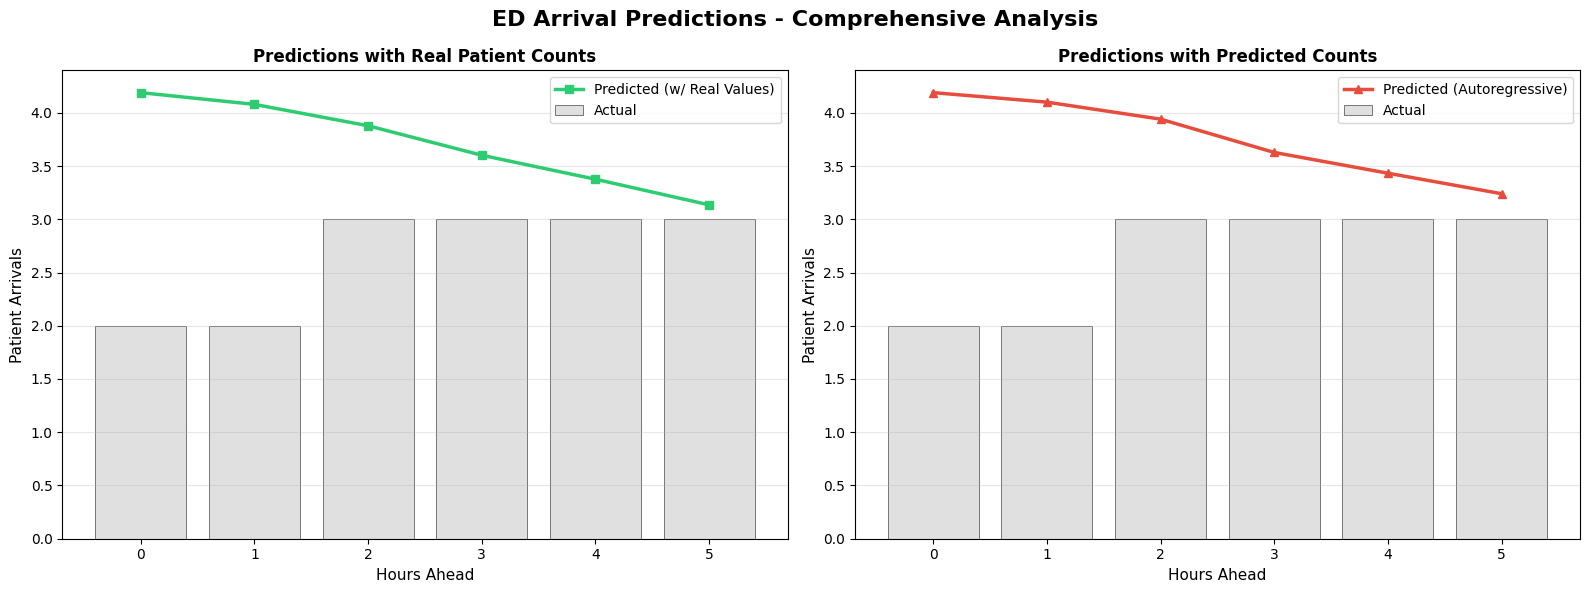

In [ ]:
def visualize_predictions(y_true, y_pred_real, y_pred_auto, timestamps=None, save_path='predictions_comparison.png'):
    print("\n[Visualization] Creating prediction comparison plots...")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('ED Arrival Predictions - Comprehensive Analysis', fontsize=16, fontweight='bold')

    hours = np.arange(len(y_true))

    # 1. Main comparison plot - Teacher Forcing
    ax1 = axes[0]
    # Bar graph for actual values
    ax1.bar(hours, y_true, label='Actual', color='lightgray', alpha=0.7, edgecolor='black', linewidth=0.5)
    # Line graph for predictions
    ax1.plot(hours, y_pred_real, 's-', label='Predicted (w/ Real Values)', color='#2ecc71', linewidth=2.5, markersize=6)
    ax1.set_xlabel('Hours Ahead', fontsize=11)
    ax1.set_ylabel('Patient Arrivals', fontsize=11)
    ax1.set_title('Predictions with Real Patient Counts', fontsize=12, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3, axis='y')

    # 2. Main comparison plot - True Autoregressive
    ax2 = axes[1]
    # Bar graph for actual values
    ax2.bar(hours, y_true, label='Actual', color='lightgray', alpha=0.7, edgecolor='black', linewidth=0.5)
    # Line graph for predictions
    ax2.plot(hours, y_pred_auto, '^-', label='Predicted (Autoregressive)', color='#e74c3c', linewidth=2.5, markersize=6)
    ax2.set_xlabel('Hours Ahead', fontsize=11)
    ax2.set_ylabel('Patient Arrivals', fontsize=11)
    ax2.set_title('Predictions with Predicted Counts', fontsize=12, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved comprehensive visualization to {save_path}")
    plt.show()

visualize_predictions(
            y_true=y_true_original,
            y_pred_real=ar_predictions_real,
            y_pred_auto=ar_predictions_pred,
            save_path='predictions_comparison.png'
        )